In [1]:
import pandas as pd
from scipy import stats
from utils import create_connection, calculate_distance
import numpy as np
import pickle as pkl
import seaborn as sns
sns.set_theme()
#import geopandas as gpd
import matplotlib.pyplot as plt
import re

# Load the Data Set for all NYC boroughs

In [2]:
# Connect to the database
database = "../data/apartments.db"
conn = create_connection(database)
c = conn.cursor()

In [3]:
# Query the database to extract all listings from NYC
nyc_counties = [
    "Manhattan County",
    "Bronx County",
    "Brooklyn",
    "Queens County",
    "Staten Island"
]

query = f"""SELECT * FROM units
            JOIN properties
            USING (property_name)
            WHERE city_name IN {str(tuple(nyc_counties))};
"""

units = pd.read_sql_query(query, conn)
conn.close()
# Correct the borough data
units.rename(columns={'city_name':'borough'}, inplace=True)
units.borough = units.borough.str.replace("County", "").str.strip()

# Correct the dishwasher column to 1s and zeros only
units.dishwasher = np.where(units.dishwasher == 'True',
                            1,
                            units.dishwasher)
units.dishwasher = np.where(units.dishwasher == 'False',
                            0,
                            units.dishwasher)
units.head()


,property_name,property_zipcode,unit_id,rent,beds,baths,sqft,date_available,date_scraped,fitness_center,...,latitude,longitude,neighborhood,zipcode,description,unique_features,borough,year_built,dishwasher,property_url
0,The Brooklyner,11201,1-06K,4060,1,1,684,2022-05-06,2022-04-05,1,...,40.69273,-73.98605,Downtown Brooklyn,11201,NO BROKER FEES. The Brooklyner known as the ta...,"Hardwood Floors, Self Guided Tours, Smoke Free...",Brooklyn,2010,1,https://www.apartments.com/the-brooklyner-broo...
1,The Brooklyner,11201,1-09H,5122,2,2,976,2022-04-05,2022-04-05,1,...,40.69273,-73.98605,Downtown Brooklyn,11201,NO BROKER FEES. The Brooklyner known as the ta...,"Hardwood Floors, Self Guided Tours, Smoke Free...",Brooklyn,2010,1,https://www.apartments.com/the-brooklyner-broo...
2,The Brooklyner,11201,1-10K,4349,1,1,618,2022-04-05,2022-04-05,1,...,40.69273,-73.98605,Downtown Brooklyn,11201,NO BROKER FEES. The Brooklyner known as the ta...,"Hardwood Floors, Self Guided Tours, Smoke Free...",Brooklyn,2010,1,https://www.apartments.com/the-brooklyner-broo...
3,The Brooklyner,11201,1-11H,5195,2,2,976,2022-04-05,2022-04-05,1,...,40.69273,-73.98605,Downtown Brooklyn,11201,NO BROKER FEES. The Brooklyner known as the ta...,"Hardwood Floors, Self Guided Tours, Smoke Free...",Brooklyn,2010,1,https://www.apartments.com/the-brooklyner-broo...
4,The Brooklyner,11201,1-16K,3997,1,1,618,2022-04-05,2022-04-05,1,...,40.69273,-73.98605,Downtown Brooklyn,11201,NO BROKER FEES. The Brooklyner known as the ta...,"Hardwood Floors, Self Guided Tours, Smoke Free...",Brooklyn,2010,1,https://www.apartments.com/the-brooklyner-broo...


In [4]:
# Fix listings that contain both in unit washer/dryer and laundry facilities
# If there's an in_unit_washer_dryer then laundry facilities should be set to zero 

units.laundry_facilities = np.where(units.in_unit_washer_dryer == 1,
                                    0,
                                    units.laundry_facilities)

In [5]:
units.dtypes

property_name           object
property_zipcode        object
unit_id                 object
rent                    object
beds                    object
baths                   object
sqft                    object
date_available          object
date_scraped            object
fitness_center           int64
air_conditioning         int64
in_unit_washer_dryer     int64
laundry_facilities       int64
car_charging             int64
roof                     int64
concierge                int64
pool                     int64
elevator                 int64
garage                   int64
dogs_allowed             int64
cats_allowed             int64
income_restrictions      int64
latitude                object
longitude               object
neighborhood            object
zipcode                 object
description             object
unique_features         object
borough                 object
year_built              object
dishwasher              object
property_url            object
dtype: o

In [6]:
pd.concat([units.isnull().sum(),units.eq('').sum()],keys=['Nulls','Empty'],axis=1)

,Nulls,Empty
property_name,0,0
property_zipcode,0,0
unit_id,0,0
rent,0,9
beds,0,0
baths,0,0
sqft,0,1301
date_available,0,0
date_scraped,0,0
fitness_center,0,0


In [7]:
# Remove all units without square feet or rent values
# It's possible to impute these missing values
# but likely will skew any results that are generated
units = units[units.sqft != '']
units = units[units.rent != '']

In [8]:
units.rent=units.rent.astype(float)
units.sqft=units.sqft.astype(float)
units.beds=units.beds.astype(int)
units.baths=units.baths.astype(float)
units.latitude=units.latitude.astype(float)
units.longitude=units.longitude.astype(float)
units.dishwasher=units.dishwasher.astype(int)

# Initial exploration

<AxesSubplot:xlabel='longitude', ylabel='latitude'>

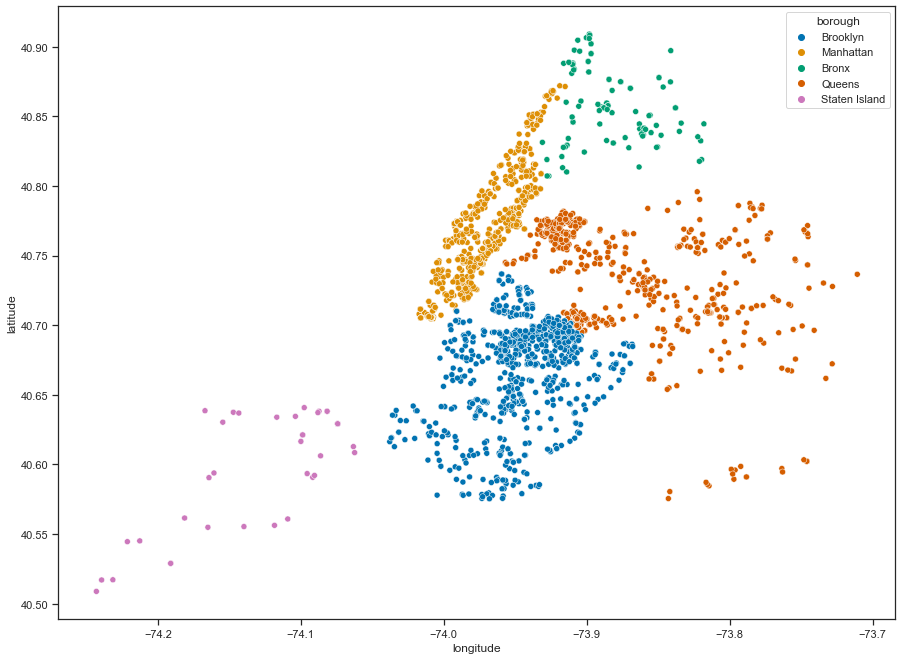

In [9]:
# Plotting the location of all the apartments
sns.set_style("ticks")
fig = plt.gcf()
scaler = abs((units.latitude.max()-units.latitude.min())/(units.longitude.max()-units.longitude.min()))
fig.set_size_inches(15, 15*scaler)

sns.scatterplot(data=units, x='longitude', y='latitude', hue = 'borough',palette='colorblind')

### Checking the data for outliers and bad data

In [10]:
# Descriptive stats based on setting a specific target column
def descriptive_stats(target,df):
    average = df.groupby('beds', as_index=True)[target].mean()
    ci_5 = df.groupby('beds', as_index=True)[target].quantile(0.05)    #5th Percentile
    ci_95 = df.groupby('beds', as_index=True)[target].quantile(0.95)   #95th Percentile
    minimum= df.groupby('beds', as_index=True)[target].min()
    maximum = df.groupby('beds', as_index=True)[target].max()
    std = df.groupby('beds', as_index=True)[target].std()
    num = df.groupby('beds', as_index=True)[target].count()
    
    stats_df = pd.DataFrame({f'Average {target}':average, 
                            '5th Percentile':ci_5,
                            '95th Percentile':ci_95,
                            'Minimum':minimum, 
                            'Maximum':maximum,
                            'Standard Deviation':std,
                            'Number of Units': num})
    
    stats_df.reset_index(inplace=True)
    return stats_df

In [11]:
# Add a price/sqft column that will be useful for visualization and detecting outliers
units['price/sqft'] = units.rent / units.sqft

In [12]:
# Get the descriptive stats for the price/sqft column
descriptive_stats('price/sqft',units)

,beds,Average price/sqft,5th Percentile,95th Percentile,Minimum,Maximum,Standard Deviation,Number of Units
0,0,12.245065,2.542254,15.000000,1.111111,2100.000000,103.935769,407
1,1,25.729248,1.949000,8.094819,0.519500,3850.000000,241.929036,817
2,2,20.724236,2.001401,7.076190,0.555556,5900.000000,280.377069,875
3,3,12.850682,1.725949,7.478107,0.626959,4799.000000,194.771262,632
4,4,33.915657,1.932507,6.871227,0.295730,6495.000000,442.704692,215
5,5,3.080949,1.508928,5.281250,0.360036,5.281250,1.137664,36
6,6,3.660153,2.272153,6.975882,1.986922,9.376471,2.182752,9


In [13]:
# Get the descriptive stats for the rent column
descriptive_stats('rent',units)

,beds,Average rent,5th Percentile,95th Percentile,Minimum,Maximum,Standard Deviation,Number of Units
0,0,2806.490172,1354.80,4531.50,1050.0,8000.0,1136.218474,407
1,1,3158.505508,1600.00,5502.20,700.0,8000.0,1336.547398,817
2,2,3594.904571,1995.00,7618.60,1500.0,12000.0,1906.269508,875
3,3,3821.359968,2270.35,7451.55,925.0,23250.0,2229.905505,632
4,4,4450.558140,2549.70,7823.50,1300.0,20775.0,2359.380757,215
5,5,5017.027778,3100.00,8462.50,2850.0,11000.0,2045.532700,36
6,6,5146.000000,1890.00,7942.00,1350.0,7970.0,2162.659878,9


In [14]:
# Get the descriptive stats for the sqft column
descriptive_stats('sqft',units)

,beds,Average sqft,5th Percentile,95th Percentile,Minimum,Maximum,Standard Deviation,Number of Units
0,0,507.953317,101.3,921.00,1.0,7200.0,404.655615,407
1,1,741.169523,500.0,1000.00,1.0,10000.0,398.800724,817
2,2,943.567429,603.5,1350.00,1.0,3600.0,306.502464,875
3,3,1130.002373,800.0,1909.45,1.0,3800.0,374.790755,632
4,4,1325.576744,835.0,2039.30,1.0,9999.0,971.536918,215
5,5,2098.472222,1200.0,6368.25,1200.0,9999.0,2095.378609,36
6,6,1636.222222,580.0,3105.60,400.0,3976.0,1007.848423,9


In [15]:
# Drop the 5 and 6 bedroom units since they make up a small portion of the dataset
units = units[units.beds < 5]

In [16]:
units[units.sqft < 51]

,property_name,property_zipcode,unit_id,rent,beds,baths,sqft,date_available,date_scraped,fitness_center,...,longitude,neighborhood,zipcode,description,unique_features,borough,year_built,dishwasher,property_url,price/sqft
464,238 Fort Washington Ave,10032,41,2995.0,3,1.0,3.0,2022-04-04,2022-04-04,0,...,-73.94155,Washington Heights,10032,NO BROKER FEE!!True 3bed steps to COLUMBIA Med...,,Manhattan,NULL,0,https://www.apartments.com/238-fort-washington...,998.333333
472,175 West 87th Street,10024,175-17A,5900.0,2,2.0,1.0,2022-04-05,2022-04-05,1,...,-73.97387,Upper West Side,10024,Elegance meets cosmopolitan flair at 175 West ...,"Bike Storage, Courtyard, Pet Friendly",Manhattan,1975,1,https://www.apartments.com/175-west-87th-stree...,5900.000000
481,529 Broome St,10013,3,4244.0,2,1.0,1.0,2022-04-05,2022-04-05,0,...,-74.00423,SoHo,10013,Great deal in Soho!large 2 bedrooms in great ...,,Manhattan,NULL,0,https://www.apartments.com/529-broome-st-new-y...,4244.000000
543,121 Madison Ave,10016,19,6495.0,4,2.0,1.0,2022-04-04,2022-04-04,0,...,-73.98450,Kips Bay,10016,This spacious convertible 4 bedroom apartment ...,,Manhattan,NULL,1,https://www.apartments.com/121-madison-ave-new...,6495.000000
544,240 W 15th St,10011,3,2600.0,1,1.0,1.0,2022-04-05,2022-04-05,0,...,-74.00110,Chelsea,10011,Sunny 1 bedroom on quiet street with dishwashe...,,Manhattan,NULL,1,https://www.apartments.com/240-w-15th-st-new-y...,2600.000000
605,159 W 72nd St,10023,10,3850.0,1,1.0,1.0,2022-04-04,2022-04-04,0,...,-73.98064,Upper West Side,10023,Newly renovated huge 1 bed in prime Upper West...,,Manhattan,NULL,0,https://www.apartments.com/159-w-72nd-st-new-y...,3850.000000
708,656 W 171st St,10032,5D,2395.0,2,1.0,5.0,2022-04-04,2022-04-04,0,...,-73.94064,Washington Heights,10032,Beautifully Renovated KING 1 BEDSteps to Colu...,,Manhattan,NULL,0,https://www.apartments.com/656-w-171st-st-new-...,479.000000
709,656 W 171st St,10032,5F,1995.0,1,1.0,5.0,2022-04-04,2022-04-04,0,...,-73.94064,Washington Heights,10032,Beautifully Renovated KING 1 BEDSteps to Colu...,,Manhattan,NULL,0,https://www.apartments.com/656-w-171st-st-new-...,399.000000
1296,618 W 142nd St,10031,1C,2195.0,1,1.0,1.0,2022-04-04,2022-04-04,0,...,-73.95318,Hamilton Heights,10031,large 1 brEntrance Foyertons of Closet spaceSe...,,Manhattan,NULL,0,https://www.apartments.com/618-w-142nd-st-new-...,2195.000000
1299,725 W 172nd St,10032,67,1895.0,1,1.0,6.0,2022-04-04,2022-04-04,0,...,-73.94186,Washington Heights,10032,NO FEEBright and Sunny two bedroomSteps to COL...,,Manhattan,NULL,0,https://www.apartments.com/725-w-172nd-st-new-...,315.833333


None of these units appear to be listings that can represent realistic expectations. As noted before, it is possible to impute these values but we will proceed for now with removing them. There are many factors that can drive the size of the unit beyond comparing to what it should be given the rent and number of bedrooms. 

In [17]:
# Drop all units less than 50sqft
units = units[units.sqft > 51]

In [18]:
units[units.sqft > 4000]

,property_name,property_zipcode,unit_id,rent,beds,baths,sqft,date_available,date_scraped,fitness_center,...,longitude,neighborhood,zipcode,description,unique_features,borough,year_built,dishwasher,property_url,price/sqft
665,22 Park Ave,10016,005C,5195.0,1,1.0,10000.0,2022-04-05,2022-04-05,1,...,-73.98088,Murray Hill,10016,This building combines the charisma of old New...,,Manhattan,NULL,0,https://www.apartments.com/22-park-ave-new-yor...,0.519500
1226,895 Park Ave,10075,895 Park Ave,8000.0,0,1.0,7200.0,2022-04-05,2022-04-05,1,...,-73.96035,Upper East Side,10075,"Upper East Side, 1.0 Bathroom, 7.0 Rooms, Heal...",,Manhattan,NULL,0,https://www.apartments.com/895-park-ave-new-yo...,1.111111
2834,445 Deisius St,10312,1st Floor and Basement,3500.0,4,3.0,4700.0,2022-04-05,2022-04-05,0,...,-74.19103,Prince's Bay,10312,Brand new construction with stainless steel ap...,,Staten Island,NULL,1,https://www.apartments.com/445-deisius-st-stat...,0.744681
2894,84 Newel St,11222,2L,2957.0,4,1.0,9999.0,2022-04-05,2022-04-05,0,...,-73.94743,Brooklyn,11222,"NO FEE! Affordable, true 4BR on a quiet block ...",,Brooklyn,NULL,0,https://www.apartments.com/84-newel-st-brookly...,0.295730
3867,551 Graham Ave,11222,3L,3800.0,4,2.0,9999.0,2022-04-05,2022-04-05,0,...,-73.94732,Greenpoint,11222,"NO FEE! True 4BR/2BA on Graham Ave, 2 blocks f...",,Brooklyn,NULL,0,https://www.apartments.com/551-graham-ave-broo...,0.380038


In [19]:
# Drop all units with more than 5,000 square feet
units = units[units.sqft < 5000]

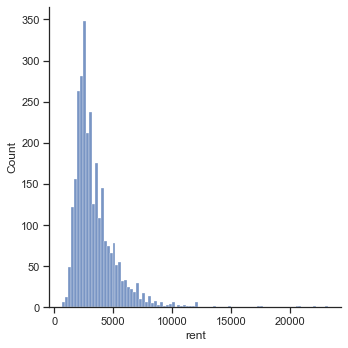

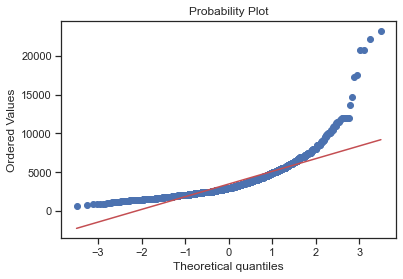

In [20]:
#Distribution of the rent column
sns.displot(units.rent)
fig = plt.figure()
res = stats.probplot(units.rent, plot=plt)

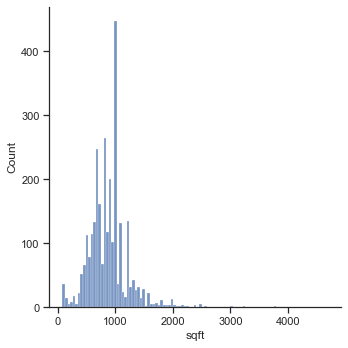

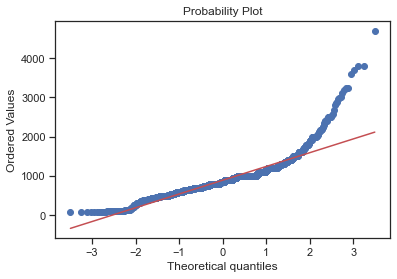

In [21]:
#Distribution of the sqft column
sns.displot(units.sqft)
fig = plt.figure()
res = stats.probplot(units.sqft, plot=plt)

In [22]:
# Detecting possible outliers with standard deviation and IQR 
def outlier_detection(target,df_input):
    
    # Adjust the distributions since they are not normal
    if target == 'rent':
        df_input.loc[:, 'rent'] = np.log(df_input.rent)
    elif target == 'sqft':
        df_input.loc[:, 'sqft'] = np.log(df_input.sqft)
    
    # Boundary zones
    average = df_input.groupby('beds', as_index=True)[target].mean()
    std = df_input.groupby('beds', as_index=True)[target].std()
    upper_limit = average + 3*std
    lower_limit = average - 3*std
    
    # Quartile Range
    iqr_25 = df_input.groupby('beds', as_index=True)[target].quantile(0.25)    
    iqr_75 = df_input.groupby('beds', as_index=True)[target].quantile(0.75)   
    iqr = iqr_75 - iqr_25
    iqr_upper = iqr_75 + iqr
    iqr_lower = iqr_25 - iqr
    
    # Set the conditions for upper limit
    cond1 = df_input[target] > df_input.beds.map(upper_limit)
    cond2 = df_input[target] > df_input.beds.map(iqr_upper)
    
    # Set the conditions for lower limit
    cond3 = df_input[target] < df_input.beds.map(lower_limit)
    cond4 = df_input[target] < df_input.beds.map(iqr_lower)

    outlier_df = df_input[(cond1 & cond2)]
    
    # Take the exponential to revert back to the original data condition
    if target == 'rent':
        outlier_df.loc[:,target] = np.exp(outlier_df.loc[:,target])
    elif target == 'sqft':
        outlier_df.loc[:,target] = np.exp(outlier_df.loc[:,target])
        
    # Filter out any income restriction units
    outlier_df = outlier_df[outlier_df.income_restrictions != 1]
    
    #stats_df.reset_index(inplace=True)
    return outlier_df

In [23]:
# Check for additional outliers in the rent column
outliers = pd.concat([outlier_detection('rent', units.copy()),outlier_detection('rent', units.copy())]).drop_duplicates()
outliers.head(10)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,property_name,property_zipcode,unit_id,rent,beds,baths,sqft,date_available,date_scraped,fitness_center,...,longitude,neighborhood,zipcode,description,unique_features,borough,year_built,dishwasher,property_url,price/sqft
232,Anagram Nomad,10016,3 Bedroom / 3 Bathroom,14748.0,3,3.0,1618.0,2022-06-04,2022-04-05,1,...,-73.98619,NoMad,10016,Now offering flexible touring options includin...,"24-Hour-Attended Lobby, Balcon, Balcony, Bicyc...",Manhattan,1998,1,https://www.apartments.com/anagram-nomad-new-y...,9.114957
408,101 West End Avenue,10023,09M,11812.0,3,3.0,1772.0,2022-04-15,2022-04-05,1,...,-73.98835,Lincoln Square,10023,"NO BROKER FEES At 101 West End Apartments, you...","24-Hour Concierge, Additional Storage, Alcove ...",Manhattan,1999,1,https://www.apartments.com/101-west-end-avenue...,6.665914
414,101 West End Avenue,10023,18F,12035.0,3,3.0,1435.0,2022-04-05,2022-04-05,1,...,-73.98835,Lincoln Square,10023,"NO BROKER FEES At 101 West End Apartments, you...","24-Hour Concierge, Additional Storage, Alcove ...",Manhattan,1999,1,https://www.apartments.com/101-west-end-avenue...,8.386760
638,The Aldyn,10069,0707,13625.0,3,3.0,1726.0,2022-05-23,2022-04-05,0,...,-73.99084,Lincoln Square,10069,"Welcome home to The Aldyn, where the best of M...","38 Rock Climbing Wall, 40,000 Sq Ft The Wright...",Manhattan,2010,1,https://www.apartments.com/the-aldyn-new-york-...,7.893975
787,165 E 66th St,10065,9F,12000.0,3,3.0,1600.0,2022-04-04,2022-04-04,0,...,-73.96330,New York,10065,Hanley New York is a luxury doorman building l...,,Manhattan,NULL,1,https://www.apartments.com/165-e-66th-st-new-y...,7.500000
864,Waterline Square Luxury Rentals,10069,One Waterline #2103,17575.0,3,2.5,1557.0,2022-04-05,2022-04-05,1,...,-73.99260,Lincoln Square,10069,Schedule your virtual appointment today!Spanni...,"30-Foot Rock Climbing Wall, Art Studio, Bowlin...",Manhattan,2019,1,https://www.apartments.com/waterline-square-lu...,11.287733
865,Waterline Square Luxury Rentals,10069,One Waterline #2204,20722.0,4,3.5,2170.0,2022-04-05,2022-04-05,1,...,-73.99260,Lincoln Square,10069,Schedule your virtual appointment today!Spanni...,"30-Foot Rock Climbing Wall, Art Studio, Bowlin...",Manhattan,2019,1,https://www.apartments.com/waterline-square-lu...,9.549309
866,Waterline Square Luxury Rentals,10069,Three Waterline #1708,20775.0,4,3.5,1966.0,2022-04-05,2022-04-05,1,...,-73.99260,Lincoln Square,10069,Schedule your virtual appointment today!Spanni...,"30-Foot Rock Climbing Wall, Art Studio, Bowlin...",Manhattan,2019,1,https://www.apartments.com/waterline-square-lu...,10.567141
869,Waterline Square Luxury Rentals,10069,Three Waterline #2901,23250.0,3,3.5,2026.0,2022-04-05,2022-04-05,1,...,-73.99260,Lincoln Square,10069,Schedule your virtual appointment today!Spanni...,"30-Foot Rock Climbing Wall, Art Studio, Bowlin...",Manhattan,2019,1,https://www.apartments.com/waterline-square-lu...,11.475814
871,Waterline Square Luxury Rentals,10069,Three Waterline #3202,22125.0,3,3.0,1823.0,2022-04-05,2022-04-05,1,...,-73.99260,Lincoln Square,10069,Schedule your virtual appointment today!Spanni...,"30-Foot Rock Climbing Wall, Art Studio, Bowlin...",Manhattan,2019,1,https://www.apartments.com/waterline-square-lu...,12.136588


In [24]:
# Drop all the extreme outliers as they represent less than 1% of the data (3+ standard deviations away)
units = units[~units.index.isin(outliers.index)]


In [25]:
# Check for additional outliers in the sqft column
outliers = pd.concat([outlier_detection('sqft', units.copy()),outlier_detection('sqft', units.copy())]).drop_duplicates()
outliers.head(10)

/opt/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,property_name,property_zipcode,unit_id,rent,beds,baths,sqft,date_available,date_scraped,fitness_center,...,longitude,neighborhood,zipcode,description,unique_features,borough,year_built,dishwasher,property_url,price/sqft
1452,281 Edgecombe Ave,10031,4A,2235.0,2,2.0,2235.0,2022-04-05,2022-04-05,0,...,-73.94359,Sugar Hill,10031,Enjoy New York City living at 281 Edgecombe Av...,,Manhattan,1920,0,https://www.apartments.com/281-edgecombe-ave-n...,1.000000
2344,11630 219th St,11411,#1,2000.0,2,1.0,3600.0,2022-04-05,2022-04-05,0,...,-73.74086,Southeast Queens,11411,"Walking distance to transportation, schools an...",,Queens,NULL,0,https://www.apartments.com/11630-219th-st-camb...,0.555556
2402,8540 102nd St,11418,1,1750.0,1,1.0,1800.0,2022-04-05,2022-04-05,0,...,-73.84649,Southeast Queens,11418,Perfect Opportunity ! On a lovely tree lined b...,,Queens,NULL,1,https://www.apartments.com/8540-102nd-st-richm...,0.972222
2663,85-11 150th St,11435,2nd Floor,2000.0,3,1.0,3190.0,2022-04-05,2022-04-05,0,...,-73.80873,Southeast Queens,11435,HUGE THREE (3) bedroom apartment for rent on 2...,,Queens,NULL,0,https://www.apartments.com/85-11-150th-st-quee...,0.626959
2834,445 Deisius St,10312,1st Floor and Basement,3500.0,4,3.0,4700.0,2022-04-05,2022-04-05,0,...,-74.19103,Prince's Bay,10312,Brand new construction with stainless steel ap...,,Staten Island,NULL,1,https://www.apartments.com/445-deisius-st-stat...,0.744681
2916,976 Fulton St,11238,976 Fulton St 5B,3241.0,1,1.0,3241.0,2022-04-05,2022-04-05,1,...,-73.96184,Clinton Hill,11238,Beautiful 7 Storie elevator building with stun...,,Brooklyn,2016,1,https://www.apartments.com/976-fulton-st-brook...,1.000000
3056,1893 Pacific St,11233,1,2750.0,1,1.0,1640.0,2022-04-05,2022-04-05,0,...,-73.92621,Weeksville,11233,BRAND NEW FURNISHED HUGE 1BEDROOM/ 1 BATHROOM ...,,Brooklyn,NULL,1,https://www.apartments.com/1893-pacific-st-bro...,1.676829
3057,1893 Pacific St,11233,2,2750.0,1,1.0,1650.0,2022-04-05,2022-04-05,0,...,-73.92621,Weeksville,11233,BRAND NEW FURNISHED HUGE 1BEDROOM/ 1 BATHROOM ...,,Brooklyn,NULL,1,https://www.apartments.com/1893-pacific-st-bro...,1.666667
3175,2680 Fulton St,11207,2680 Fulton St,2000.0,2,1.0,2880.0,2022-04-05,2022-04-05,1,...,-73.89568,Cypress Hills,11207,Beautiful huge newly renovated 2 bedrooms apar...,,Brooklyn,NULL,1,https://www.apartments.com/2680-fulton-st-broo...,0.694444
3179,9502 Foster Ave,11236,9502 Foster Ave,1800.0,1,1.0,3020.0,2022-04-05,2022-04-05,1,...,-73.90716,Canarsie,11236,"Canarsie1 Bedroom apartment with EIK , Living ...",,Brooklyn,NULL,1,https://www.apartments.com/9502-foster-ave-bro...,0.596026


In [26]:
# Check for additional outliers in the price/sqft column
outliers = pd.concat([outlier_detection('price/sqft', units.copy()),outlier_detection('price/sqft', units.copy())]).drop_duplicates()
outliers.head(10)

,property_name,property_zipcode,unit_id,rent,beds,baths,sqft,date_available,date_scraped,fitness_center,...,longitude,neighborhood,zipcode,description,unique_features,borough,year_built,dishwasher,property_url,price/sqft
76,31 E 30th St,10016,3C,3200.0,2,1.0,300.0,2022-04-04,2022-04-04,0,...,-73.98405,Kips Bay,10016,"Location, location, location!Very close to Ame...",,Manhattan,NULL,0,https://www.apartments.com/31-e-30th-st-new-yo...,10.666667
106,1628 2nd Ave Unit 4N,10028,4N,4500.0,0,1.0,100.0,2022-04-05,2022-04-05,0,...,-73.95226,Upper East Side,10028,(*Unfurnished or Furnished*)****SuN-Drenched S...,,Manhattan,NULL,1,https://www.apartments.com/1628-2nd-ave-new-yo...,45.000000
198,120 E 10th St,10003,4,8450.0,4,2.0,900.0,2022-07-01,2022-04-04,0,...,-73.98817,East Village,10003,120 E 10th St is an apartment located inManhat...,,Manhattan,NULL,0,https://www.apartments.com/120-e-10th-st-new-y...,9.388889
299,622 East 11th Street,10009,05,2750.0,2,2.0,300.0,2022-06-01,2022-04-05,1,...,-73.97860,Alphabet City,10009,Want to live in a NYC apartment building that ...,"Citi Bike Station Nearby, Dishwasher*, Duplex*...",Manhattan,1900,1,https://www.apartments.com/622-east-11th-stree...,9.166667
343,126 Rivington St,10002,4A,4999.0,3,1.5,100.0,2022-04-05,2022-04-05,0,...,-73.98702,Lower East Side,10002,"Fantastic apartment features hardwood floors, ...",,Manhattan,NULL,0,https://www.apartments.com/126-rivington-st-ne...,49.990000
697,629 W 57th St,10019,2354,9995.0,2,2.0,1000.0,2022-04-04,2022-04-04,0,...,-73.99215,Lincoln Square,10019,Features Laundry in Unit Private Outdoor...,,Manhattan,NULL,1,https://www.apartments.com/629-w-57th-st-new-y...,9.995000
842,View 34,10016,S23H,5869.0,1,1.0,587.0,2022-04-09,2022-04-04,1,...,-73.97257,Murray Hill,10016,View 34 is the new destination for upscale liv...,"Bicycle storage room, Bookcase divider, Build ...",Manhattan,1985,0,https://www.apartments.com/view-34-new-york-ny...,9.998296
959,315 N End Ave,10282,7S,8200.0,2,2.0,900.0,2022-04-04,2022-04-04,1,...,-74.00597,Downtown Manhattan,10282,Luxurious 2 BR / 2 BA Apartment located in Bea...,,Manhattan,NULL,1,https://www.apartments.com/315-n-end-ave-new-y...,9.111111
962,543 East 5th Street,10009,01,3550.0,2,2.0,300.0,2022-04-05,2022-04-05,1,...,-73.98238,Alphabet City,10009,543 East 5th Street is a 6 story walk up that ...,"Citi Bike Station Nearby, Decorative Fireplace...",Manhattan,1900,1,https://www.apartments.com/543-east-5th-street...,11.833333
964,FOUND Study Upper East Side - Student Housing,10075,2,1500.0,1,1.0,132.0,2022-04-05,2022-04-05,0,...,-73.95369,Lenox Hill,10075,FOUND Study Upper East Side offers fully furni...,Student Housing,Manhattan,1920,1,https://www.apartments.com/found-study-upper-e...,11.363636


In [27]:
# Drop all the extreme outliers as they represent less than 1% of the data (3+ standard deviations away)
units = units[~units.index.isin(outliers.index)]

### Add in additional location featurs
* Distance to wall street and midtown manhattan
* Distance to nearest MTA stop
* Neighbourhood cluster id (to replace zipcode and neighborhood)

In [28]:
# Load MTA Stop locations and clean to useable form
# Data comes in the form of: POINT(LAT LONG)
mta_stops = pd.read_csv('../data/external/nyc/mta_locations.csv')['the_geom']
mta_stops.replace('[POINT()]', '',regex=True, inplace=True)
mta_stops = mta_stops.str.strip()
mta_stops = pd.DataFrame(mta_stops.str.split(' ').to_list())
mta_stops.rename(columns={0:'lon', 1: 'lat'}, inplace=True)
mta_stops.lat=mta_stops.lat.astype(float)
mta_stops.lon=mta_stops.lon.astype(float)
mta_stops.drop_duplicates(inplace=True)
mta_stops.head()

,lon,lat
0,-73.868356,40.849169
1,-73.868213,40.849128
2,-73.873499,40.841223
3,-73.872892,40.841453
4,-73.879623,40.840815


In [29]:
# Define the locations of wall street and midtown
midtown = {'lat': 40.752148801459604, 'lon': -73.98749979654413}
wall_street = {'lat': 40.70773721622127, 'lon': -74.0101688916038}

In [30]:
# Calculate the nearest MTA stop for each listing
units['dist_transit']=units.apply(lambda row: calculate_distance(row.latitude, row.longitude, mta_stops.lat, mta_stops.lon).min(), axis=1)

In [31]:
# Calculate the distance to wall street and midtown
units['dist_midtown']=units.apply(lambda row: calculate_distance(row.latitude, row.longitude, midtown['lat'], midtown['lon']), axis=1)
units['dist_wall_street']=units.apply(lambda row: calculate_distance(row.latitude, row.longitude, wall_street['lat'], wall_street['lon']), axis=1)

In [35]:
names = list(units.neighborhood.unique())

### Remove extra columns that aren't useful for visualizing or the model

In [108]:
drop_columns = ['latitude', 'longitude', 'zipcode', 'unique_features', 'year_built', 'property_url', 'property_zipcode', 'unit_id', 'date_available', 'date_scraped', 'description']
units.drop(columns=drop_columns, inplace = True)
units.head()

,property_name,rent,beds,baths,sqft,fitness_center,air_conditioning,in_unit_washer_dryer,laundry_facilities,car_charging,...,garage,dogs_allowed,cats_allowed,income_restrictions,borough,dishwasher,price/sqft,dist_transit,dist_midtown,dist_wall_street
0,The Brooklyner,4060.0,1,1.0,684.0,1,1,1,0,0,...,1,1,1,0,Brooklyn,1,5.935673,0.026536,4.106145,1.634417
1,The Brooklyner,5122.0,2,2.0,976.0,1,1,1,0,0,...,1,1,1,0,Brooklyn,1,5.247951,0.026536,4.106145,1.634417
2,The Brooklyner,4349.0,1,1.0,618.0,1,1,1,0,0,...,1,1,1,0,Brooklyn,1,7.037217,0.026536,4.106145,1.634417
3,The Brooklyner,5195.0,2,2.0,976.0,1,1,1,0,0,...,1,1,1,0,Brooklyn,1,5.322746,0.026536,4.106145,1.634417
4,The Brooklyner,3997.0,1,1.0,618.0,1,1,1,0,0,...,1,1,1,0,Brooklyn,1,6.467638,0.026536,4.106145,1.634417


# Visualization

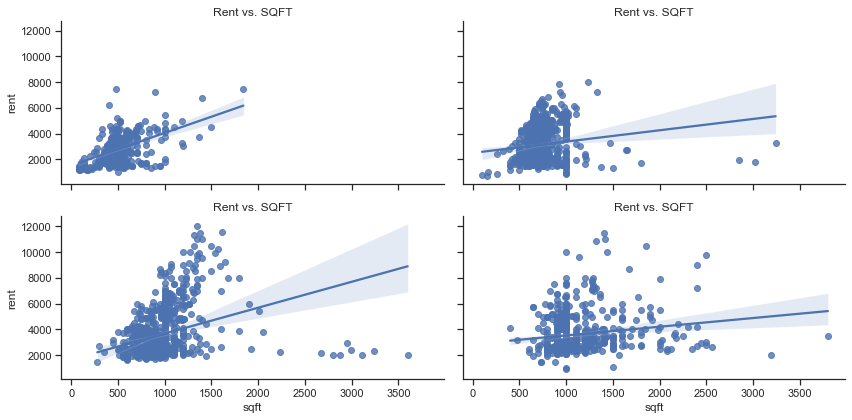

In [110]:
# Plot rent versus sqft for each bedroom size
g = sns.FacetGrid(units[units.beds<4], col='beds', col_wrap = 2, aspect = 2)
g.map(sns.regplot,'sqft','rent').set(title='Rent vs. SQFT')

In [111]:
# Add a price/sqft column that will be useful for visualization
units['price/sqft'] = units.rent / units.sqft

In [112]:
# Visualize the relationship between price/sqft and distance to MTA stops

def transit_distance_plot(borough: str, df):
    # Filter for the specified borough
    df.loc[:,:] = df[df.loc[:,'borough'] == borough]
    
    # Create distance bins based on distance to MTA stops
    # Look at binning for every 1/8th of a mile
    bins = np.arange(0.00, 0.600000, 0.100000)
    labels = bins[1:]
    df.loc[:,'transit_dist_bin'] = pd.cut(df.loc[:,"dist_transit"], bins=bins, labels=labels)
    
    # Create the boxplots
    plt.figure()
    sns.boxplot(x = 'transit_dist_bin', y = 'price/sqft', data = df)
    plt.title(f'{borough}')
    plt.show()
    plt.close()
    

/opt/anaconda3/lib/python3.9/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


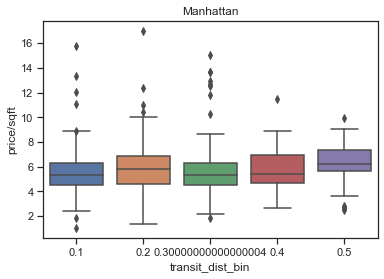

/opt/anaconda3/lib/python3.9/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


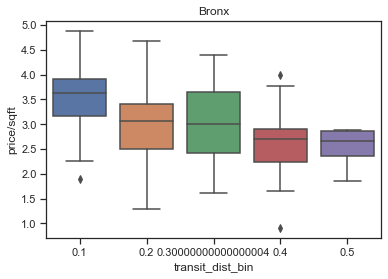

/opt/anaconda3/lib/python3.9/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


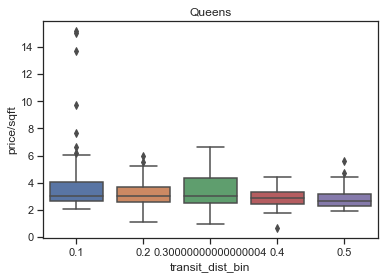

/opt/anaconda3/lib/python3.9/site-packages/pandas/io/formats/format.py:1429: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  for val, m in zip(values.ravel(), mask.ravel())


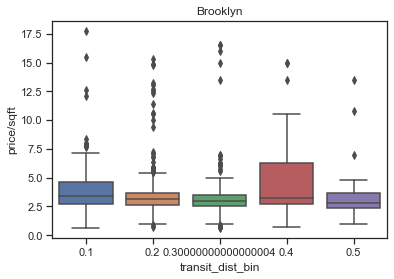

In [113]:
boroughs = ['Manhattan', 'Bronx', 'Queens', 'Brooklyn']
for borough in boroughs:
    transit_distance_plot(f'{borough}', units.copy())

Not surprisingly, the distance to an MTA stop in Manhattan doesn't have too much of a relationship with the price/sqft. There does seem to be a relationship within the other boroughs.

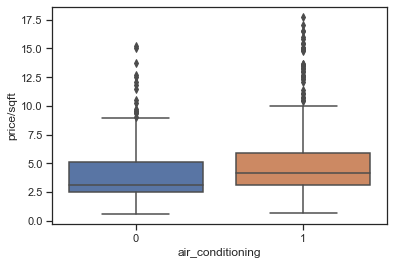

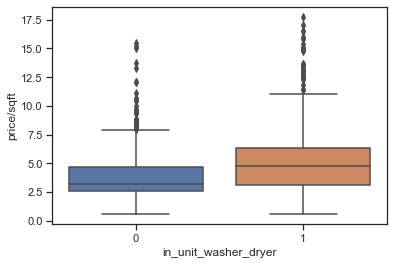

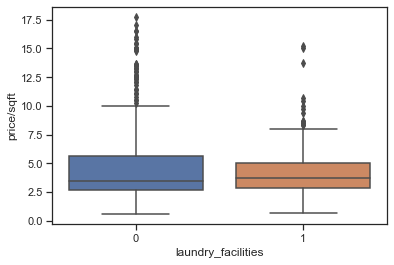

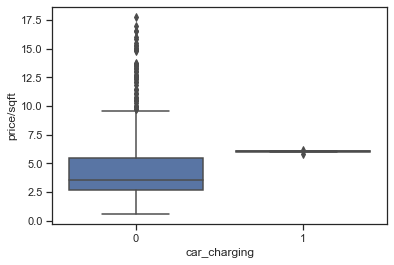

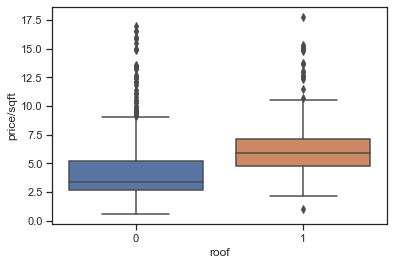

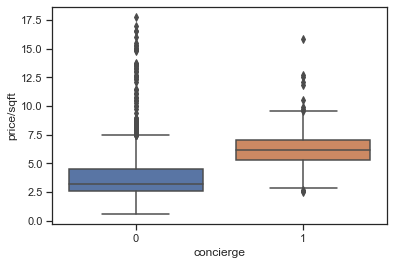

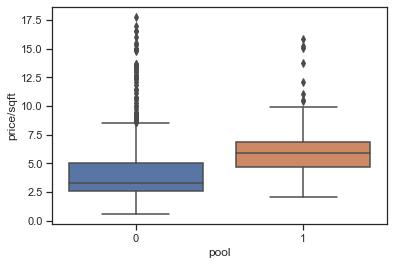

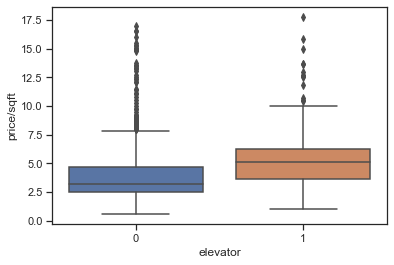

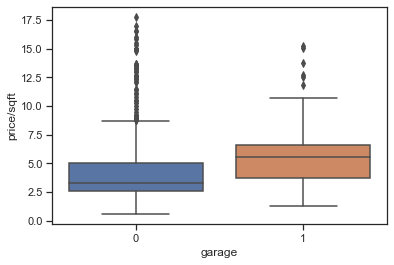

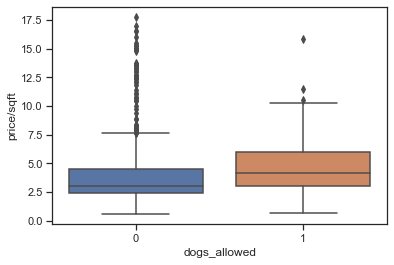

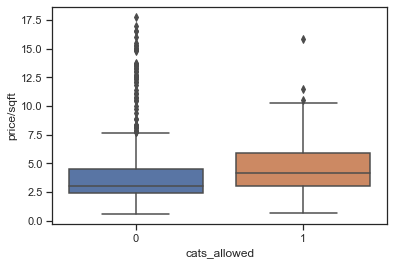

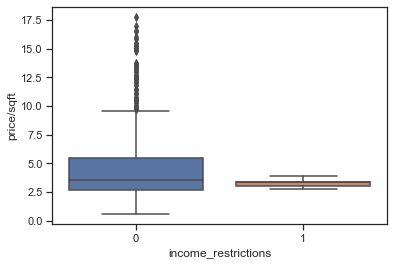

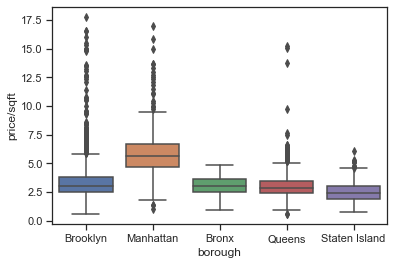

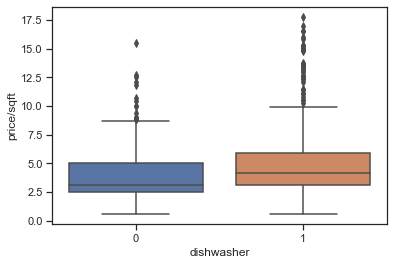

In [114]:
#plotting binary features
for i in units.columns[6:20]:
  plt.figure()
  sns.boxplot(x = i, y = 'price/sqft', data = units)
  plt.show()
  plt.close()

Car charging stations and income restrictions appear to have a very unbalanced data set. Both of these columns should be dropped as they will not contribute to the model.

In [115]:
# Drop income restrictions, car charging and price/sqft
units.drop(columns={'car_charging', 'income_restrictions', 'price/sqft'}, inplace=True)

<AxesSubplot:>

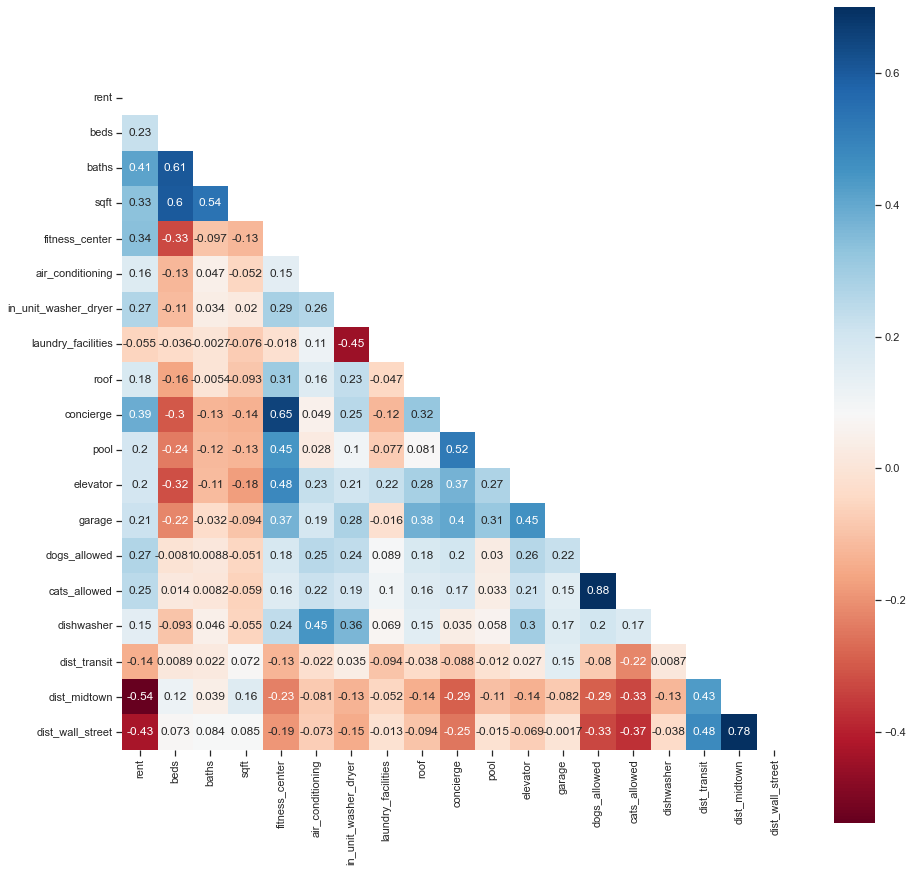

In [116]:
corr_map = units.corr()

# Create a mask
mask = np.triu(np.ones_like(corr_map, dtype=bool))

f,ax = plt.subplots(figsize = (15,15))
sns.heatmap(corr_map, square = True, vmax = 0.7, cmap = 'RdBu', annot = True, mask = mask)

The following updates to the dataset seem necessary to consolidate similar features:
* Combine dogs and cats into a single pet category
* Drop distance to wall street and keep distance to midtown

In [117]:
# Create new pets category
units['pets_allowed']=np.where((units.dogs_allowed == 1) | (units.cats_allowed == 1),
                               1,
                               0)

# Drop columns
units.drop(columns={'dist_wall_street', 'dogs_allowed', 'cats_allowed'}, inplace=True)

# Data processing

In [118]:
units.head()

,property_name,rent,beds,baths,sqft,fitness_center,air_conditioning,in_unit_washer_dryer,laundry_facilities,roof,concierge,pool,elevator,garage,borough,dishwasher,dist_transit,dist_midtown,pets_allowed
0,The Brooklyner,4060.0,1,1.0,684.0,1,1,1,0,0,1,0,1,1,Brooklyn,1,0.026536,4.106145,1
1,The Brooklyner,5122.0,2,2.0,976.0,1,1,1,0,0,1,0,1,1,Brooklyn,1,0.026536,4.106145,1
2,The Brooklyner,4349.0,1,1.0,618.0,1,1,1,0,0,1,0,1,1,Brooklyn,1,0.026536,4.106145,1
3,The Brooklyner,5195.0,2,2.0,976.0,1,1,1,0,0,1,0,1,1,Brooklyn,1,0.026536,4.106145,1
4,The Brooklyner,3997.0,1,1.0,618.0,1,1,1,0,0,1,0,1,1,Brooklyn,1,0.026536,4.106145,1
